In [7]:
# This notebook have built from this tutorial: https://github.com/bnsreenu/python_for_microscopists/blob/master/330_Detectron2_Instance_3D_EM_Platelet.ipynb
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
from src.segmentation.framework_handlers.detectron2_handler import print_version_info

!nvcc --version
print_version_info()

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Aug_15_21:14:11_PDT_2021
Cuda compilation tools, release 11.4, V11.4.120
Build cuda_11.4.r11.4/compiler.30300941_0
torch:  1.9 ; cuda:  11.1
detectron2: 0.6


In [12]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# load the best model config and weights
checkpoint_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-34-05_all_train_images/model_final.pth"
config_yaml_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-34-05_all_train_images/config.yaml"
cfg = get_cfg()
# load config
cfg.merge_from_file(config_yaml_path)
# define predictor
# load checkpoint
cfg.MODEL.WEIGHTS = checkpoint_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Loading config /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-34-05_all_train_images/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[01/01 09:31:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-34-05_all_train_images/model_final.pth ...


In [16]:
# Function to calculate the area of a bounding box
def calculate_area(box):
    x1, y1, x2, y2 = box
    return (x2 - x1) * (y2 - y1)

# Function to process and visualize a single image
def process_and_visualize_image(image_path, predictor, class_mapping, color_mapping):
    image = cv2.imread(image_path)
    outputs = predictor(image)
    pred_classes = outputs['instances'].pred_classes.cpu().tolist()
    pred_boxes = outputs['instances'].pred_boxes.tensor.cpu().numpy()
    scores = outputs['instances'].scores.cpu().tolist()

    # Draw colored bounding boxes based on class
    for box, class_id in zip(pred_boxes, pred_classes):
        x1, y1, x2, y2 = box.astype(int)
        class_name = class_mapping.get(class_id, 'unknown')
        color = color_mapping.get(class_name, (0, 0, 0))  # Default color: black
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    areas = [calculate_area(box) for box in pred_boxes]
    return pred_classes, scores, areas

# Function to process images in a folder and calculate statistics
def process_images(folder_path, predictor):
    class_mapping = {1: 'clear', 2: 'cloudy', 3: 'amber'}  # Update based on your model's class IDs
    color_mapping = {'clear': (128, 128, 128), 'cloudy': (255, 255, 255), 'amber': (255, 165, 0)}  # Grey, White, Orange
    
    class_counts = {'clear': 0, 'cloudy': 0, 'amber': 0}
    class_areas = {'clear': [], 'cloudy': [], 'amber': []}
    class_scores = {'clear': [], 'cloudy': [], 'amber': []}

    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            pred_classes, scores, areas = process_and_visualize_image(image_path, predictor, class_mapping, color_mapping)

            for class_id, score, area in zip(pred_classes, scores, areas):
                class_name = class_mapping.get(class_id, 'unknown')
                if class_name in class_counts:
                    class_counts[class_name] += 1
                    class_areas[class_name].append(area)
                    class_scores[class_name].append(score)

    # Calculate additional statistics
    total_count = sum(class_counts.values())
    proportions = {k: (v / total_count * 100) if total_count > 0 else 0 for k, v in class_counts.items()}
    avg_scores = {k: np.mean(v) if v else 0 for k, v in class_scores.items()}
    avg_areas = {k: np.mean(v) if v else 0 for k, v in class_areas.items()}

    return class_counts, proportions, avg_scores, avg_areas

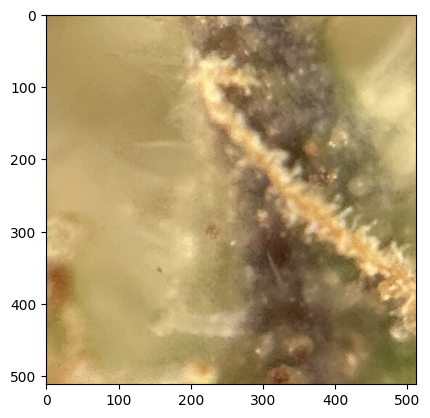

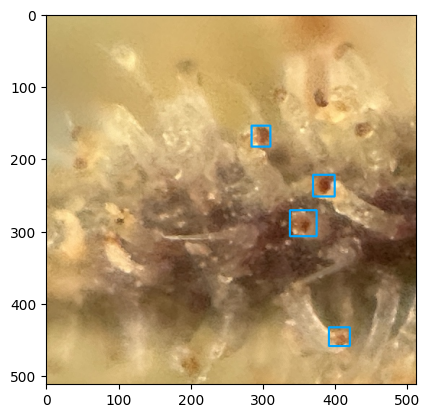

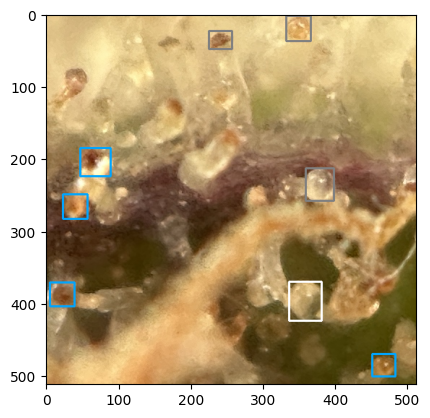

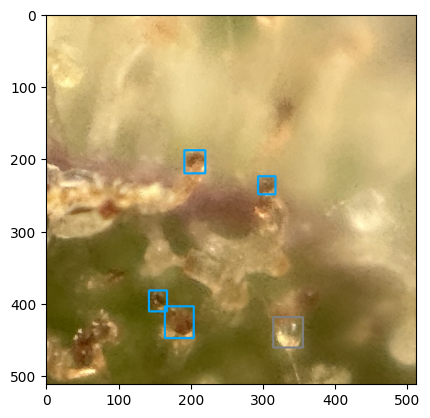

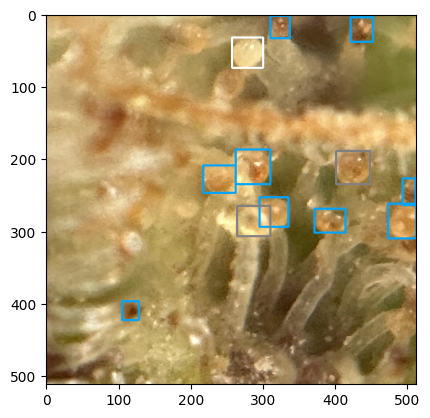

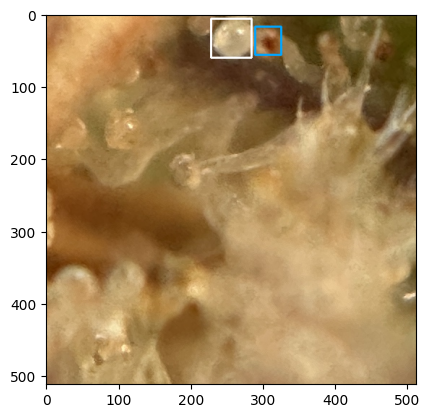

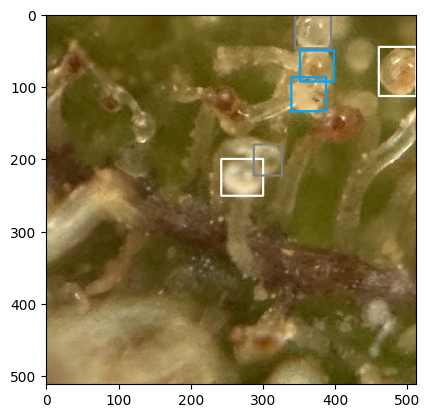

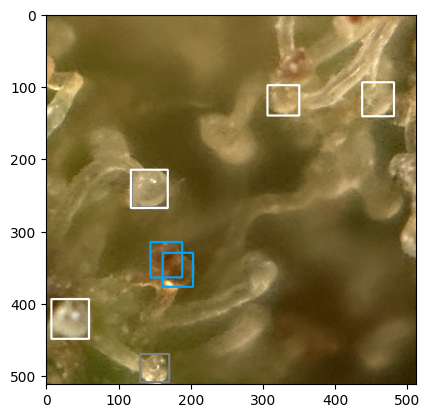

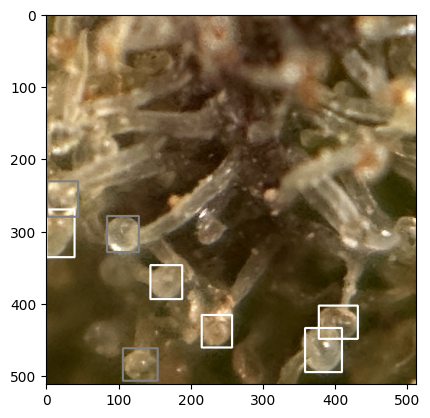

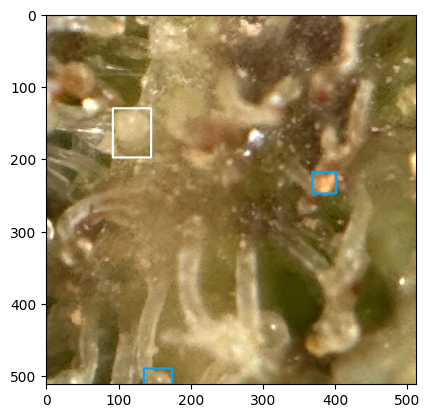

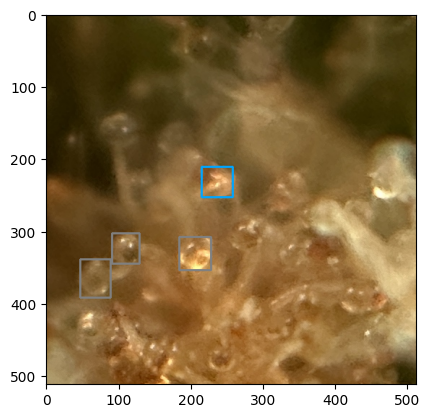

Counts: {'clear': 16, 'cloudy': 15, 'amber': 29}
Proportions: {'clear': 26.666666666666668, 'cloudy': 25.0, 'amber': 48.333333333333336}
Average Confidence Scores: {'clear': 0.9761881567537785, 'cloudy': 0.9813576102256775, 'amber': 0.9746522348502586}
Average Areas: {'clear': 1881.306, 'cloudy': 2601.2803, 'amber': 1317.7782}


In [18]:
import config
week = "week9"
zoom_type = "3xr"
image_number = "IMG_2250"
folder_path = f"/home/etaylor/images/processed_images/cannabis_patches/{config.WEEKS_DIR[week]}/3x_regular/{image_number}"
counts, proportions, avg_scores, avg_areas = process_images(folder_path, predictor)

print("Counts:", counts)
print("Proportions:", proportions)
print("Average Confidence Scores:", avg_scores)
print("Average Areas:", avg_areas)